### Import statements and configuration

In [ ]:
import copy
import sys
import timeit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Generic setup

In [2]:
# init RNG
np.random.seed(42)

# plotting in notebook
%matplotlib inline

### Helper functions

In [46]:
# numpy native method
def auto_corr_func(x):
    x = np.atleast_1d(x) # to make sure we have 1d array
    N = x.size # will get zero-padding
    x = x - np.mean(x) # center
    acf = np.correlate(x, x, mode='full') # native acf
    acf = acf[acf.size // 2:] # cut to original size 
    acf /= acf[0] # normalize
    return acf 

In [ ]:
# not used as the native numpy method is ~4x faster
def auto_corr_func_fft(x):
    x = np.atleast_1d(x) # to make sure we have 1d array
    N = x.size # will need zero-padding for FFT
    x = x - np.mean(x) # center
    f = np.fft.fft(x, N*2-1) # FFT with padding
    acf = np.real(np.fft.ifft(f * np.conjugate(f), N*2-1)[:N]) #invFFT and cut to original size 
    acf /= acf[0] # normalize
    return acf

## Swendsen-Wang

### Definite class for running Swendsen-Wang algorithm

In [146]:
class SwendsenWang:
    def __init__(self, T, L, W=None, H=None, J=1.0, verbose=False):
        self.T = T # temperature T
        self.L = L # lattice side length L
        if W is None: # lattice width if given
            self.W = self.L
        if H is None: # lattice height if given
            self.H = self.L
        self.J = J # magnetic coupling constant
        
        # 3d lattice dimensions
        self.N = self.L * self.W * self.H
      
        # inverse temperature
        self.beta = 1.0 / self.T
          
        # bond probability: key element when building new clusters e/a step
        self.bond_prob = 1.0 - np.exp(-2 * self.beta * self.J)
        
        # number of bonds in fully connected lattice
        self.n_bonds = 3 * self.N # periodic boundary conditions
    
        # starting energy
        self.ene_start = - self.J * self.n_bonds # n_bonds fully connecting all-up spins
    
        if verbose:
            print('Lattice: {} x {} x {} -> {} sites'.format(self.L, self.W, self.H, self.N))
            print('Temperature T = {:.3f} -> inverse temperature beta = {:.3f}'.format(self.T, self.beta))
            print('Bond probability = {:.3f}'.format(self.bond_prob))
    
        # set up lattice, graph coordinates, cluster_ids
        self.spins = np.ones((self.L, self.W, self.H), dtype=int) # all spins up
        self.neighborhood = np.empty((*self.spins.shape, 6, 3), dtype=int) # L**3 lattice, 6 neighbors/site, 3 coordinates/neighbor              
        self.cluster_ids = np.zeros(self.spins.shape, dtype=int) # init to zero
        self.masses = np.ones(self.spins.shape, dtype=int) # init to one
        self.parents = np.empty((*self.spins.shape, 3), dtype=int) # space for L*W*H lattice, 3 coordinates/parent
        for site in np.ndindex(self.spins.shape):
            self.parents[site] = site # init parent coordinates to self for all sites
            self.neighborhood[site] = self.find_neighbors(*site) # populate neighbor coordinates
            
    def reset_clusters(self):
        self.cluster_ids = np.zeros(self.spins.shape, dtype=int) # init to zero
        self.masses = np.ones(self.spins.shape, dtype=int) # init to one
        self.parents = np.empty((*self.spins.shape, 3), dtype=int) # space for L*W*H lattice, 3 coordinates/parent
        for site in np.ndindex(self.spins.shape):
            self.parents[site] = site # init parent coordinates to self for all sites
            
            
    def find_neighbors(self, i, j, k):
        L_m, W_m, H_m = self.L - 1, self.W - 1, self.H - 1  # save [L, W, H] - 1 for efficient reuse
        return (((i+1) if i < L_m else 0, j, k), # east
                (i, (j+1) if j < W_m else 0, k), # south
                (i, j, (k+1) if k < H_m else 0), # up
                ((i-1) if i > 0 else L_m, j, k), # west
                (i, (j-1) if j > 0 else W_m, k), # north
                (i, j, (k-1) if k > 0 else H_m)) # down
    
    def union(self, site_a, site_b):
        if site_a == site_b: # do nothing if called on same site (periodic boundary conditions)
            return site_a
        root_a, root_b = self.find(site_a), self.find(site_b) # find roots of respective clusters
        if root_a == root_b:
            return root_a # do nothing if already part of same cluster
        mass_a, mass_b = self.masses[root_a], self.masses[root_b] # find masses of respective clusters
        if mass_a < mass_b: # lighter cluster will be adopted by heavier cluster: swap places if necessary
            root_a, root_b = root_b, root_a
        self.parents[root_b] = root_a # adopt cluster of site_b into cluster of site_a
        self.masses[root_a] += self.masses[root_b] # add mass of adopted cluster to mass of adopting cluster
        return root_a
    
    def is_root(self, site):
        return tuple(self.parents[site]) == site # end of recursion: site is root if it's its own parent
    
    def find(self, site):
        while not self.is_root(site): # follow up the tree until root is found
            site = tuple(self.parents[site])
        return site    
    
    def label_clusters(self):
        n_clusters = 0 # running count of clusters in lattice
        for site in np.ndindex(self.spins.shape):
            if self.is_root(site):
                self.cluster_ids[site] = n_clusters # pass 1: e/a cluster's root gets numbered
                n_clusters += 1
        cluster_sizes = np.zeros(n_clusters, dtype=float) # keep a tally of cluster sizes
        for site in np.ndindex(self.spins.shape):
            cluster_id = self.cluster_ids[tuple(self.parents[site])] # find which cluster id site belongs to
            self.cluster_ids[site] = cluster_id # pass 2: e/a site gets cluster id of its root
            cluster_sizes[cluster_id] += 1
        return n_clusters, cluster_sizes
    
    def union_find(self, plot_slice=False):
        n_active_bonds = 0 # init to zero, used to calculate energy ene
        self.reset_clusters() # reset cluster data (cluster_id, masses, parents) at beginning of step

        for site in np.ndindex(self.spins.shape):
            spin = self.spins[site] # site's own spin
            bond_neighbors = [tuple(neighbor) for neighbor in self.neighborhood[site][:3] if # add neighbor if it has same spin and...
                              spin == self.spins[tuple(neighbor)] and np.random.rand() < self.bond_prob] # ... passes Monte Carlo step
            n_active_bonds += len(bond_neighbors) # count active bonds in lattice as we're not saving them for later
            [self.union(site, bond_neighbor) for bond_neighbor in bond_neighbors] # run union-find on all bonded neighbors
        n_clusters, cluster_sizes = self.label_clusters() # now label all found clusters
        if plot_slice: # plot slice 0 of the spin lattice with colored clusters for diagnostics
            plt.figure()
            plt.imshow(self.cluster_ids[:, :, 0].reshape(self.spins.shape[:-1]), cmap=cm.get_cmap('PiYG', n_clusters))
            plt.colorbar()
        return n_active_bonds, n_clusters, cluster_sizes # to do calculations with

    def auto_correlate(self, observable_t0, observable_t): # not production: to test a hunch regarding autocorrelation
        N = np.sum(observable_t0.size)
        return 2 * np.count_nonzero(observable_t0 == observable_t) / N - 1
    
    def update(self, thermalize=False):
        # Run union-find algorithm and get clusters
        n_active_bonds, n_clusters, cluster_sizes = self.union_find() 
        
        # Flip clusters
        new_spins = np.random.randint(0, 2, size=n_clusters) * 2 - 1 # 1d table: p=0.5 random -1, +1 for n_clusters
        for site in np.ndindex(self.spins.shape):
            self.spins[site] = new_spins[self.cluster_ids[site]] # grab new random spin from table
            
        if thermalize: # save the trouble of calculating observables while thermalizing
            return None
        
        # Calculate observables
        mag = np.abs(np.mean(self.spins)) # magnetization density over lattice
        ene = -n_active_bonds * self.J # check if this is ok, but don't need it for Binder cumulant
        auto_corr = self.auto_correlate(self.spins_t0, self.spins)
        return mag, ene, auto_corr #, mag_2, mag_4
    
    def run(self, thermalization_steps=50, time_steps=50):
        for _ in range(thermalization_steps):
            self.update(thermalize=True) # thermalize
        
        self.spins_t0 = copy.deepcopy(self.spins) # after thermalization, take spins snapshot for autocorrelation calc
        mag_array = np.empty(time_steps)
        ene_array = np.empty(time_steps)
        auto_corr_array = np.empty(time_steps)

        for i in range(time_steps):
            mag_array[i], ene_array[i], auto_corr_array[i] = self.update() # MC steps with observable recording
        
        return mag_array, ene_array, auto_corr_array #mag_2_array, mag_4_array, 

### Set parameters

In [147]:
# magnetic coupling constant
J = 1.0

# lattice cubic side lengths
L_range = [8, 12, 16, 20]

# temperatures
T_range = [3, 4, 4.4, 4.515, 4.6, 5, 6]

# thermalization steps
thermalize = 20

# observation time steps
time_steps = 20

# samples: number of fresh starts
samples = 20

### Run simulations

----------------------------------------------------------------------------------------------------
L = 8, T = 3.000 : 9.368s simulation time for 20 samples over 800 total sweeps (20*[20+20]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.000 : 7.852s simulation time for 20 samples over 800 total sweeps (20*[20+20]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.400 : 7.312s simulation time for 20 samples over 800 total sweeps (20*[20+20]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.515 : 7.198s simulation time for 20 samples over 800 total sweeps (20*[20+20]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.600 : 7.114s simulation time for 20 samples over 800 total swe

----------------------------------------------------------------------------------------------------
L = 20, T = 6.000 : 101.939s simulation time for 20 samples over 800 total sweeps (20*[20+20]) on 8000 sites


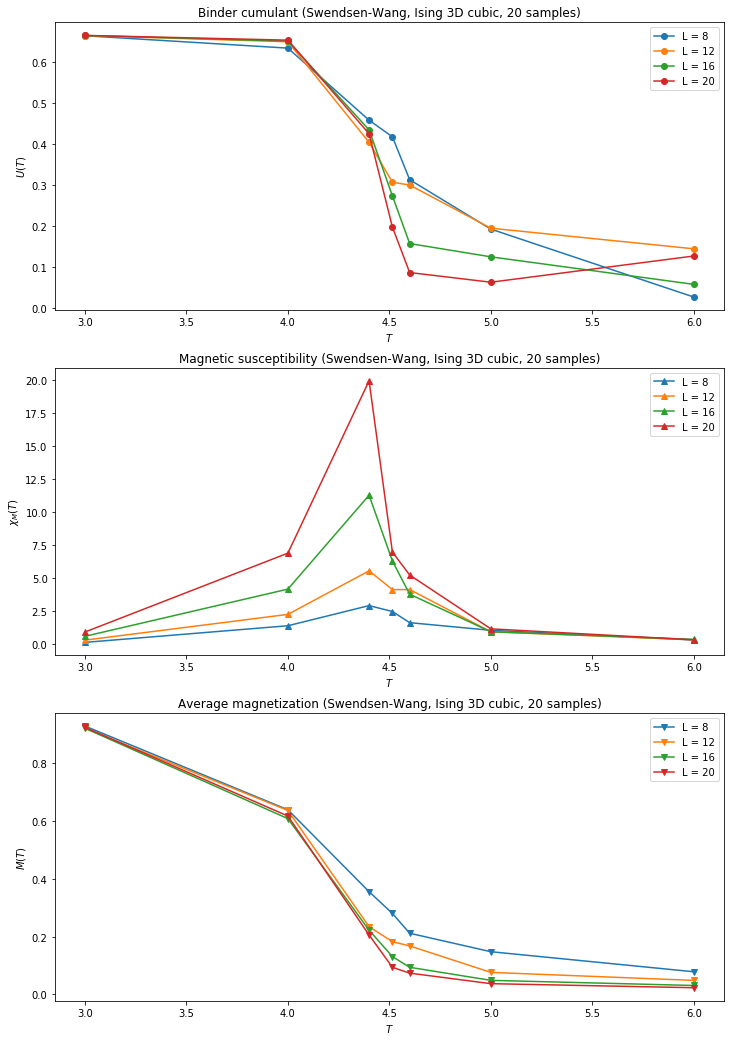

In [148]:
result_mag = np.empty((len(L_range), len(T_range)))
result_mag_2 = np.zeros_like(result_mag)
result_mag_4 = np.zeros_like(result_mag)
result_ene = np.zeros_like(result_mag)
result_binder = np.zeros_like(result_mag)
result_chi = np.zeros_like(result_mag)

result_run_auto_corr = np.empty((len(L_range), len(T_range), time_steps))
result_mag_auto_corr = np.empty((len(L_range), len(T_range), time_steps))

plt.close('all')
f, axarr = plt.subplots(3, 1, figsize=(12, 18))

for i, L in enumerate(L_range):
    for j, T in enumerate(T_range):
        
        mag_avg = np.empty(samples)
        mag_2_avg = np.empty(samples)
        mag_4_avg = np.empty(samples)
        ene_avg = np.empty(samples)
        binder = np.empty(samples)
        chi = np.empty(samples)
        
        run_auto_corr = np.empty((samples, time_steps))
        mag_auto_corr = np.empty((samples, time_steps))
        
        start = timeit.default_timer()

        for n in range(samples):
            simulation = SwendsenWang(T, L)
            mag_time, ene_time, auto_corr_time = simulation.run(thermalize, time_steps)
            
            mag_avg[n] = np.mean(mag_time)
            mag_2_avg[n] = np.mean(mag_time**2)
            mag_4_avg[n] = np.mean(mag_time**4)
            ene_avg[n] = np.mean(ene_time)
            
            binder[n] = 1 - mag_4_avg[n] / (3 * mag_2_avg[n]**2)
            chi[n] = L**3 / T * (mag_2_avg[n] - mag_avg[n]**2)
            
            run_auto_corr[n] = auto_corr_time
            mag_auto_corr[n] = auto_corr_func(mag_time)
        
        end = timeit.default_timer()
        
        print(100 * '-')
        print('L = {}, T = {:.3f} : {:.3f}s simulation time for {} samples over {} total sweeps ({}*[{}+{}]) on {} sites'.format(L, T, end-start, samples, samples*(thermalize+time_steps), samples, thermalize, time_steps, L**3))
        print(100 * '=')
        
        result_mag[i, j] = np.mean(mag_avg)
        result_mag_2[i, j] = np.mean(mag_2_avg)
        result_mag_4[i, j] = np.mean(mag_4_avg)
        result_ene[i, j] = np.mean(ene_avg)
        result_binder[i, j] = np.mean(binder)
        result_chi[i, j] = np.mean(chi)
        result_run_auto_corr[i, j] = np.mean(run_auto_corr, axis=0)
        result_mag_auto_corr[i, j] = np.mean(mag_auto_corr, axis=0)
        
    axarr[0].plot(T_range, result_binder[i], 'o-', label='L = {}'.format(L))
    axarr[1].plot(T_range, result_chi[i], '^-', label='L = {}'.format(L))
    axarr[2].plot(T_range, result_mag[i], 'v-', label='L = {}'.format(L))

axarr[0].set_title('Binder cumulant (Swendsen-Wang, Ising 3D cubic, {} samples)'.format(samples))
axarr[1].set_title('Magnetic susceptibility (Swendsen-Wang, Ising 3D cubic, {} samples)'.format(samples))
axarr[2].set_title('Average magnetization (Swendsen-Wang, Ising 3D cubic, {} samples)'.format(samples))
        
axarr[0].set_xlabel('$T$')
axarr[0].set_ylabel('$U(T)$')
axarr[0].legend()

axarr[1].set_xlabel('$T$')
axarr[1].set_ylabel('$\chi_M(T)$')
axarr[1].legend()

axarr[2].set_xlabel('$T$')
axarr[2].set_ylabel('$M(T)$')
axarr[2].legend()

f.savefig('Swendsen_Wang.pdf', dpi=300)

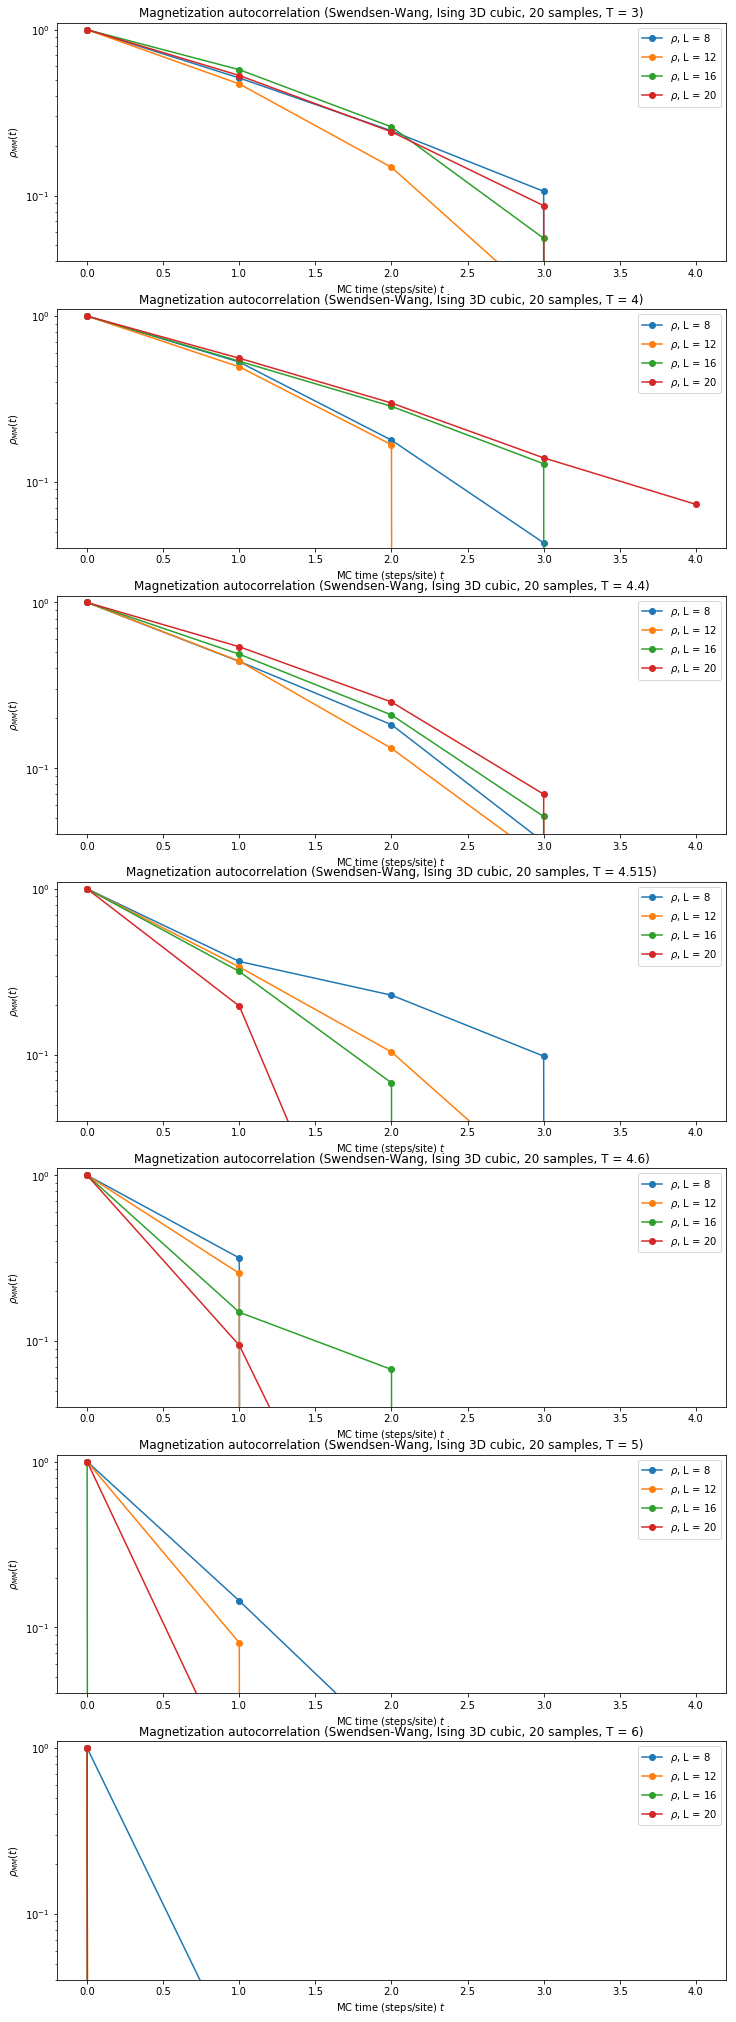

In [149]:
plt.close('all')
f, axarr = plt.subplots(len(T_range), 1, figsize=(12, 36))
for i, T in enumerate(T_range):
    axarr[i].set_title('Magnetization autocorrelation (Swendsen-Wang, Ising 3D cubic, {} samples, T = {})'.format(samples, T))
        
    axarr[i].set_xlabel('MC time (steps/site) $t$')
    axarr[i].set_ylabel('$\\rho_{MM} (t)$')
    axarr[i].set_ylim(0.04, 1.1)

    for j, L in enumerate(L_range):
        axarr[i].semilogy(result_mag_auto_corr[j, i,:5],'o-', label='$\\rho$, L = {}'.format(L))
#         axarr[i].semilogy(result_run_auto_corr[j, i,:10],'^-', label='$\\rho_r L = {}$'.format(L))
    axarr[i].legend()


plt.savefig('autocorr_Swendsen_Wang.pdf', dpi=300)

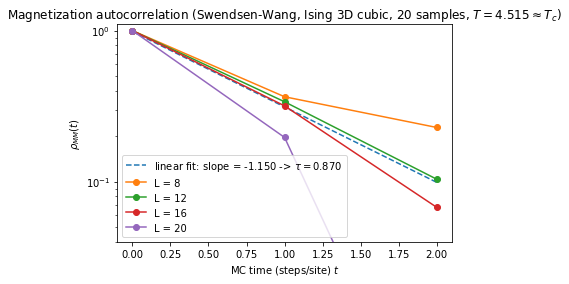

In [150]:
t = 3
p = np.polyfit(range(t), np.log(np.mean(result_mag_auto_corr[:, 3, :t], axis=0)), 1)
plt.semilogy(range(t), np.exp(range(t) * p[0] + p[1]), '--', label='linear fit: slope = {:.3f} -> $\\tau={:.3f}$'.format(p[0], -1/p[0]))
for j, L in enumerate(L_range):
    plt.semilogy(result_mag_auto_corr[j, 3,:t],'o-', label='L = {}'.format(L))
plt.legend()
plt.xlabel('MC time (steps/site) $t$')
plt.ylabel('$\\rho_{MM} (t)$')
plt.ylim(0.04, 1.1)
plt.title('Magnetization autocorrelation (Swendsen-Wang, Ising 3D cubic, {} samples, $T = 4.515 \\approx T_c$)'.format(samples))
plt.savefig('tau_Swendsen_Wang.pdf', dpi=300)

## Metropolis

### Definite class for running Metropolis algorithm

In [123]:
class Metropolis:
    def __init__(self, T, L, W=None, H=None, J=1.0, verbose=False):
        self.T = T # temperature T
        self.L = L # lattice side length L
        if W is None: # lattice width if given
            self.W = self.L
        if H is None: # lattice height if given
            self.H = self.L
        self.J = J # magnetic coupling constant
        
        # 3d lattice dimensions
        self.N = self.L * self.W * self.H
      
        # inverse temperature
        self.beta = 1.0 / self.T
          
        # precalculate element for deltaE
        self.J_beta_2 = self.J * self.beta * 2
            
        # energy starting value
        self.ene = -6 * self.J * self.N / 2 # e/a site contributes 1 per 6 neighbors, double counting 
    
        # magnetization starting value
        self.mag = self.N
        
        if verbose:
            print('Lattice: {} x {} x {} -> {} sites'.format(self.L, self.W, self.H, self.N))
            print('Temperature T = {:.3f} -> inverse temperature beta = {:.3f}'.format(self.T, self.beta))
    
        # set up lattice, graph coordinates, cluster_ids
        self.spins = np.ones((self.L, self.W, self.H), dtype=int) # all spins up
        self.neighborhood = np.empty((*self.spins.shape, 6, 3), dtype=int) # L**3 lattice, 6 neighbors/site, 3 coordinates/neighbor              

        for site in np.ndindex(self.spins.shape):
            self.neighborhood[site] = self.find_neighbors(*site) # populate neighbor coordinates
                        
    def find_neighbors(self, i, j, k):
        L_m, W_m, H_m = self.L - 1, self.W - 1, self.H - 1  # save [L, W, H] - 1 for efficient reuse
        return (((i+1) if i < L_m else 0, j, k), # east
                (i, (j+1) if j < W_m else 0, k), # south
                (i, j, (k+1) if k < H_m else 0), # up
                ((i-1) if i > 0 else L_m, j, k), # west
                (i, (j-1) if j > 0 else W_m, k), # north
                (i, j, (k-1) if k > 0 else H_m)) # down
    
    def auto_correlate(self, observable_t0, observable_t): # not production: to test a hunch regarding autocorrelation
        N = np.sum(observable_t0.size)
        return 2 * np.count_nonzero(observable_t0 == observable_t) / N - 1
    
    def update(self, thermalize=False):   
        # Choose site and possibly flip
        site = tuple((np.random.randint(self.L), np.random.randint(self.W), np.random.randint(self.H)))
        spin = self.spins[site]
        eta_accept = np.random.rand()
        n_neighbors = np.sum([self.spins[tuple(neighbor)] for neighbor in self.neighborhood[site]])
        delta_ene = np.exp(-spin * self.J_beta_2 * n_neighbors)
        if delta_ene > eta_accept:
            self.spins[site] *= -1
            self.mag -= 2 * spin
            self.ene += 2 * self.J * spin * n_neighbors
        if thermalize:
            return None
        
        auto_corr = self.auto_correlate(self.spins_t0, self.spins)
        return self.mag/self.N, self.ene/self.N, auto_corr
    
    def run(self, thermalization_steps=100000, time_steps=100, decorr_steps=100000):
        for _ in range(thermalization_steps):
            self.update(thermalize=True) # thermalize
        
        self.spins_t0 = copy.deepcopy(self.spins) # after thermalization, take spins snapshot for autocorrelation calc
        mag_array = np.empty(time_steps)
        ene_array = np.empty(time_steps)
        auto_corr_array = np.empty(time_steps)

        for i in range(time_steps):
            for _ in range(decorr_steps):
                self.update()
            mag_array[i], ene_array[i], auto_corr_array[i] = self.update() # MC steps with observable recording
            
        return mag_array, ene_array, auto_corr_array

### Set parameters

In [128]:
# magnetic coupling constant
J = 1.0

# lattice cubic side lengths
L_range = [8, 12, 16, 20]

# temperatures
T_range = [3, 4, 4.4, 4.515, 4.6, 5, 6]

# thermalization sweeps
thermalize = 100

# observation time steps
time_steps = 20

# decorrelation sweeps
decorr_sweeps = 1

# samples: number of fresh starts
samples = 20

### Run simulations

----------------------------------------------------------------------------------------------------
L = 8, T = 3.000 : 31.617s simulation time for 20 samples over 2400 total sweeps (20*[100+20*1]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.000 : 33.007s simulation time for 20 samples over 2400 total sweeps (20*[100+20*1]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.400 : 33.269s simulation time for 20 samples over 2400 total sweeps (20*[100+20*1]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.515 : 34.209s simulation time for 20 samples over 2400 total sweeps (20*[100+20*1]) on 512 sites
----------------------------------------------------------------------------------------------------
L = 8, T = 4.600 : 34.233s simulation time for 20 sampl

----------------------------------------------------------------------------------------------------
L = 20, T = 6.000 : 565.875s simulation time for 20 samples over 2400 total sweeps (20*[100+20*1]) on 8000 sites


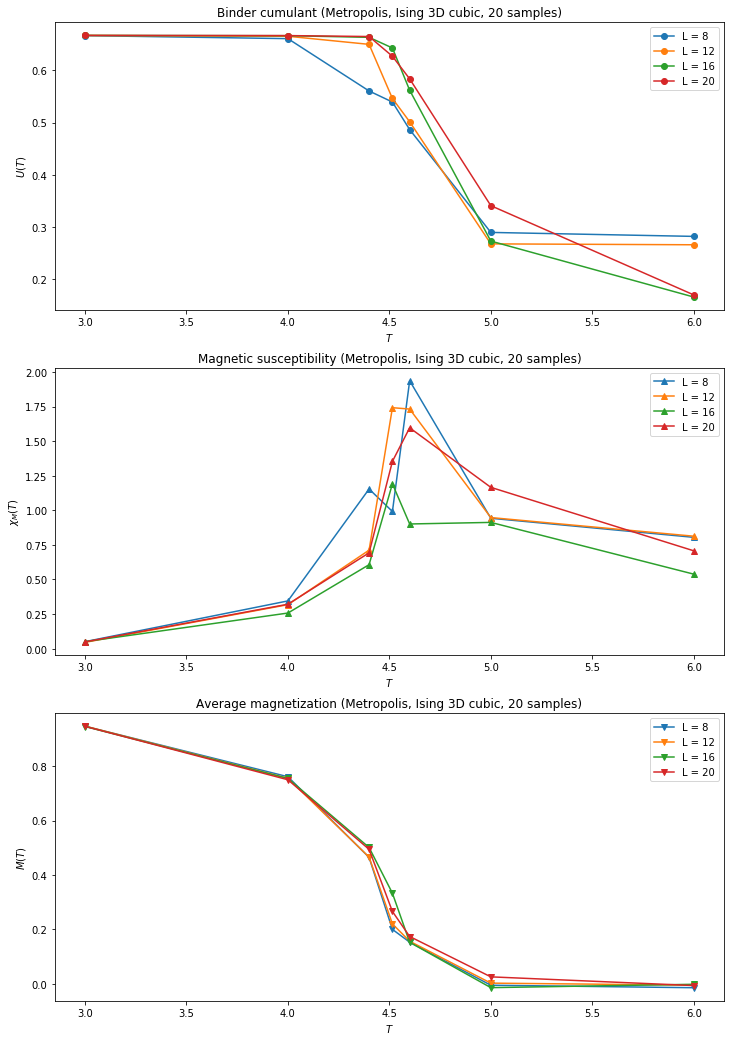

In [130]:
result_mag = np.empty((len(L_range), len(T_range)))
result_mag_2 = np.zeros_like(result_mag)
result_mag_4 = np.zeros_like(result_mag)
result_ene = np.zeros_like(result_mag)
result_binder = np.zeros_like(result_mag)
result_chi = np.zeros_like(result_mag)

result_run_auto_corr = np.empty((len(L_range), len(T_range), time_steps))
result_mag_auto_corr = np.empty((len(L_range), len(T_range), time_steps))

plt.close('all')
f, axarr = plt.subplots(3, 1, figsize=(12, 18))

for i, L in enumerate(L_range):
    for j, T in enumerate(T_range):
        
        mag_avg = np.empty(samples)
        mag_2_avg = np.empty(samples)
        mag_4_avg = np.empty(samples)
        ene_avg = np.empty(samples)
        binder = np.empty(samples)
        chi = np.empty(samples)
        
        run_auto_corr = np.empty((samples, time_steps))
        mag_auto_corr = np.empty((samples, time_steps))
        
        start = timeit.default_timer()

        for n in range(samples):
            simulation = Metropolis(T, L)
            mag_time, ene_time, auto_corr_time = simulation.run(thermalize*L**3, time_steps, decorr_sweeps*L**3)
            mag_avg[n] = np.mean(mag_time)
            mag_2_avg[n] = np.mean(mag_time**2)
            mag_4_avg[n] = np.mean(mag_time**4)
            ene_avg[n] = np.mean(ene_time)
            
            binder[n] = 1 - mag_4_avg[n] / (3 * mag_2_avg[n]**2)
            chi[n] = L**3 / T * (mag_2_avg[n] - mag_avg[n]**2)
            
            run_auto_corr[n] = auto_corr_time
            mag_auto_corr[n] = auto_corr_func(mag_time)
        
        end = timeit.default_timer()
        
        print(100 * '-')
        print('L = {}, T = {:.3f} : {:.3f}s simulation time for {} samples over {} total sweeps ({}*[{}+{}*{}]) on {} sites'.format(L, T, end-start, samples, samples*(thermalize+time_steps*decorr_sweeps), samples, thermalize, time_steps, decorr_sweeps, L**3))
        print(100 * '=')
        
        result_mag[i, j] = np.mean(mag_avg)
        result_mag_2[i, j] = np.mean(mag_2_avg)
        result_mag_4[i, j] = np.mean(mag_4_avg)
        result_ene[i, j] = np.mean(ene_avg)
        result_binder[i, j] = np.mean(binder)
        result_chi[i, j] = np.mean(chi)
        result_run_auto_corr[i, j] = np.mean(run_auto_corr, axis=0)
        result_mag_auto_corr[i, j] = np.mean(mag_auto_corr, axis=0)
        
    axarr[0].plot(T_range, result_binder[i], 'o-', label='L = {}'.format(L))
    axarr[1].plot(T_range, result_chi[i], '^-', label='L = {}'.format(L))
    axarr[2].plot(T_range, result_mag[i], 'v-', label='L = {}'.format(L))

axarr[0].set_title('Binder cumulant (Metropolis, Ising 3D cubic, {} samples)'.format(samples))
axarr[1].set_title('Magnetic susceptibility (Metropolis, Ising 3D cubic, {} samples)'.format(samples))
axarr[2].set_title('Average magnetization (Metropolis, Ising 3D cubic, {} samples)'.format(samples))
        
axarr[0].set_xlabel('$T$')
axarr[0].set_ylabel('$U(T)$')
axarr[0].legend()

axarr[1].set_xlabel('$T$')
axarr[1].set_ylabel('$\chi_M(T)$')
axarr[1].legend()

axarr[2].set_xlabel('$T$')
axarr[2].set_ylabel('$M(T)$')
axarr[2].legend()

f.savefig('Metropolis.pdf', dpi=300)

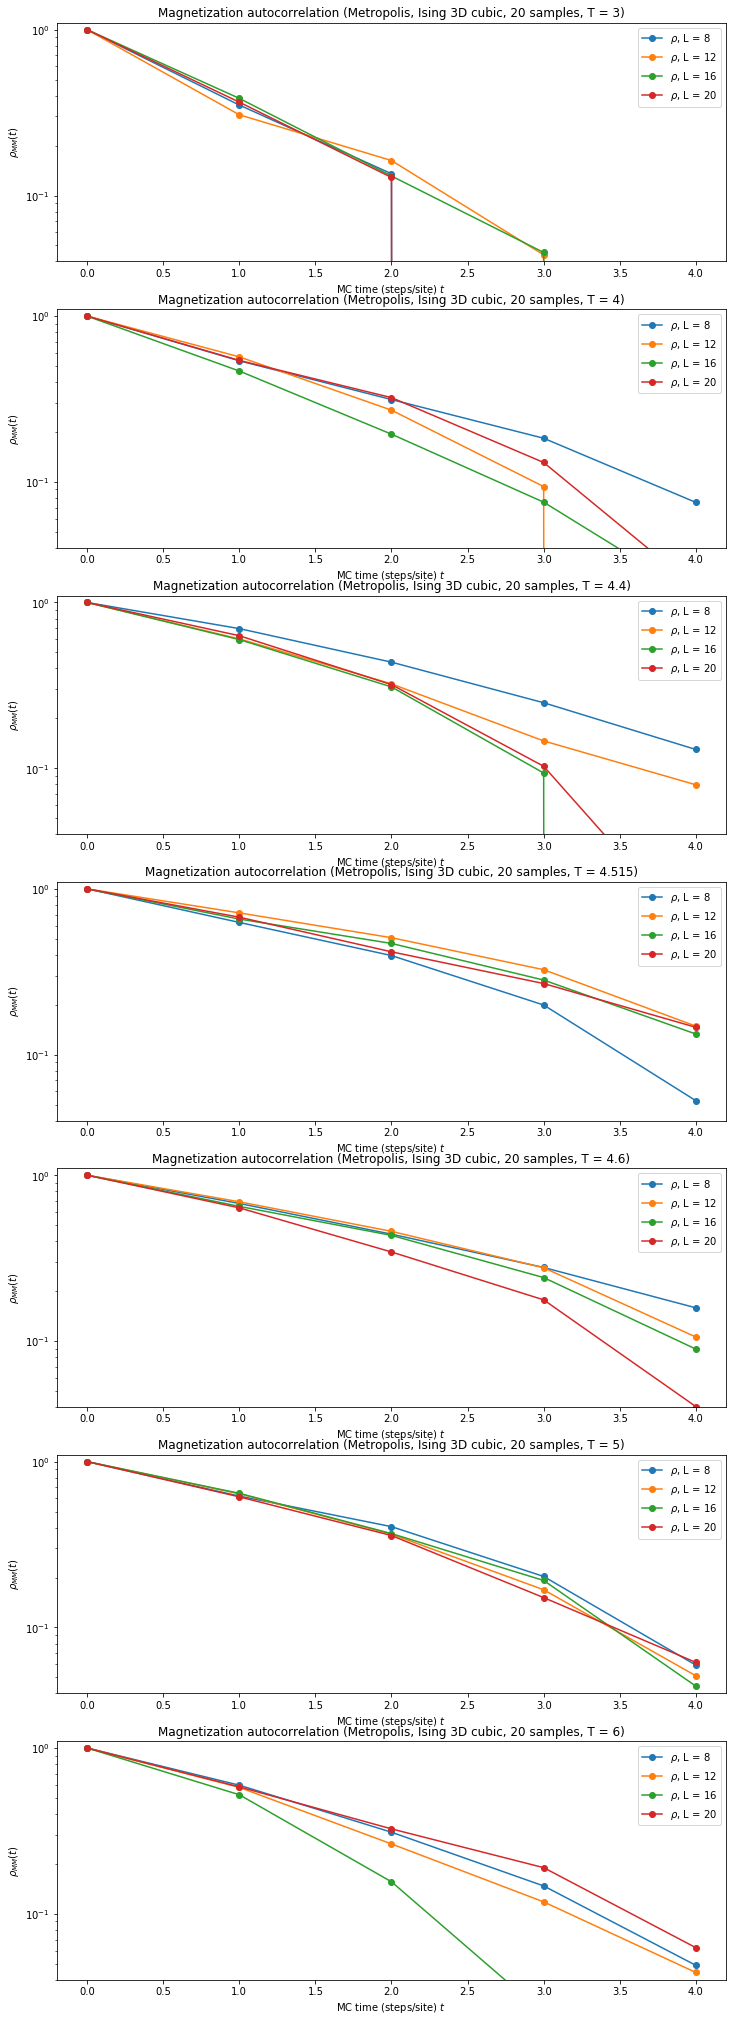

In [145]:
plt.close('all')
f, axarr = plt.subplots(len(T_range), 1, figsize=(12, 36))
for i, T in enumerate(T_range):
    axarr[i].set_title('Magnetization autocorrelation (Metropolis, Ising 3D cubic, {} samples, T = {})'.format(samples, T))
        
    axarr[i].set_xlabel('MC time (steps/site) $t$')
    axarr[i].set_ylabel('$\\rho_{MM} (t)$')
    axarr[i].set_ylim(0.04, 1.1)

    for j, L in enumerate(L_range):
        axarr[i].semilogy(result_mag_auto_corr[j, i,:5],'o-', label='$\\rho$, L = {}'.format(L))
#         axarr[i].semilogy(result_run_auto_corr[j, i,:10],'^-', label='$\\rho_r L = {}$'.format(L))
    axarr[i].legend()


plt.savefig('autocorr_Metropolis.pdf', dpi=300)

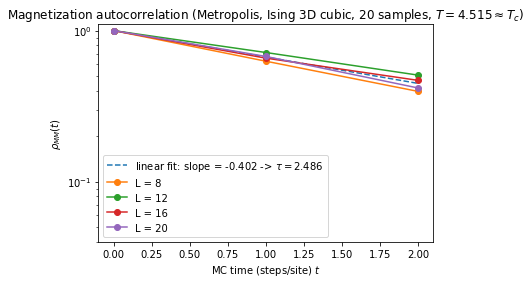

In [144]:
t = 3
p = np.polyfit(range(t), np.log(np.mean(result_mag_auto_corr[:, 3, :t], axis=0)), 1)
plt.semilogy(range(t), np.exp(range(t) * p[0] + p[1]), '--', label='linear fit: slope = {:.3f} -> $\\tau={:.3f}$'.format(p[0], -1/p[0]))
for j, L in enumerate(L_range):
    plt.semilogy(result_mag_auto_corr[j, 3,:t],'o-', label='L = {}'.format(L))
plt.legend()
plt.xlabel('MC time (steps/site) $t$')
plt.ylabel('$\\rho_{MM} (t)$')
plt.ylim(0.04, 1.1)
plt.title('Magnetization autocorrelation (Metropolis, Ising 3D cubic, {} samples, $T = 4.515 \\approx T_c$)'.format(samples))
plt.savefig('tau_Metropolis.pdf', dpi=300)